### 1. Baseline 셋팅하기

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 2. 라이브러리와 데이터 가져오기

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


In [3]:
data_dir = os.path.join(os.getenv('HOME'), 'work/kaggle_kakr_housing/data')
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = os.path.join(data_dir, 'train.csv')
sub_data_path = os.path.join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/home/jovyan/work/kaggle_kakr_housing/data/train.csv
/home/jovyan/work/kaggle_kakr_housing/data/test.csv


### 3. data 이해하기

In [4]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print(f'train data dim : {data.shape}')
print(f'sub data dim : {sub.shape}')

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [5]:
y = data['price']
del data['price']

# 테스트 데이터에는 price 가 없어서 컬럼이 하나 작음
# y = data['price']로 하고, data['price'] 제거
print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
# ✓ 학습 데이터와 테스트 데이터 합치기
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [7]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 전처리

<Axes: >

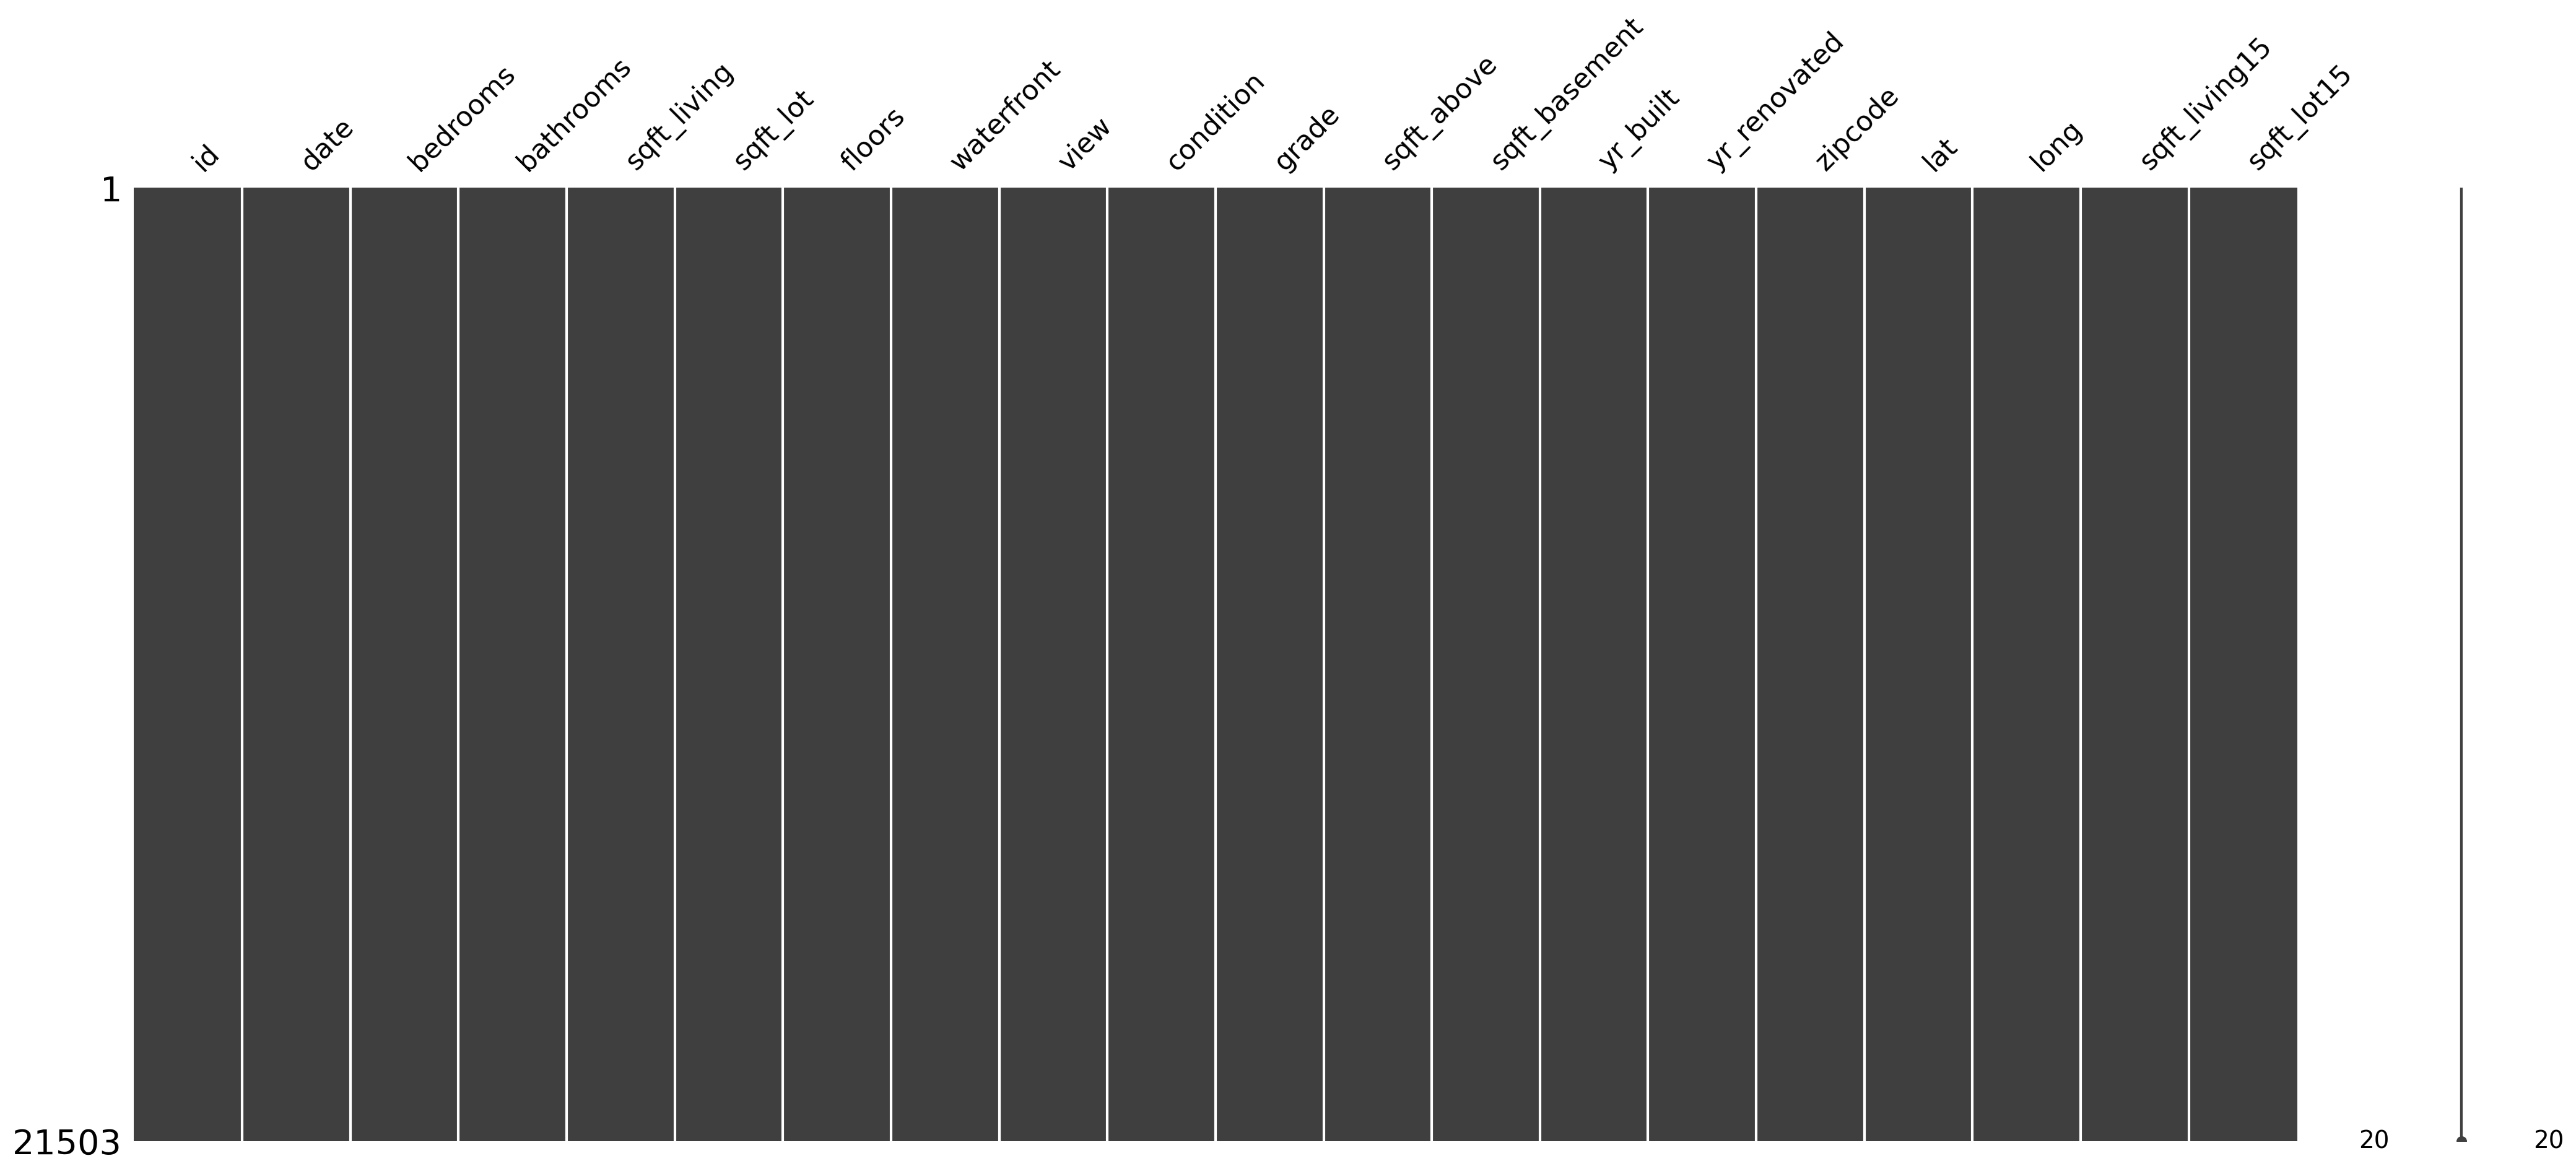

In [8]:
# ✓ 간단한 전처리(missingno 라이브러리를 사용)

msno.matrix(data)

In [9]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [10]:
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [11]:
# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')

id: 0


In [12]:
# 한 번에 뿅!
# 추가 : 위에 실행했던 코드는 f-string으로 작동하지만 해당 코드는 대괄호가 2개가 있어 f-string으로 표현하면 에러가 발생합니다. 이럴 경우 format으로 실행합니다.
# 추가에 대한 내용 : https://blockdmask.tistory.com/429
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


In [13]:
# 4. id 컬럼 외에도 모든 컬럼에 적용
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [14]:
# 5. 필요없는 id 변수 정리
sub_id = data['id'][train_len:]
del data['id']

# 필요 없는 id 컬럼을 제거합니다. 
# 나중에 예측 결과를 제출할 때를 대비하여 sub_id 변수에 id 칼럼을 저장해두고 지우도록 하겠습니다.
print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [15]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [16]:
# 6 date 컬럼에서 필요없는 부분 제거
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


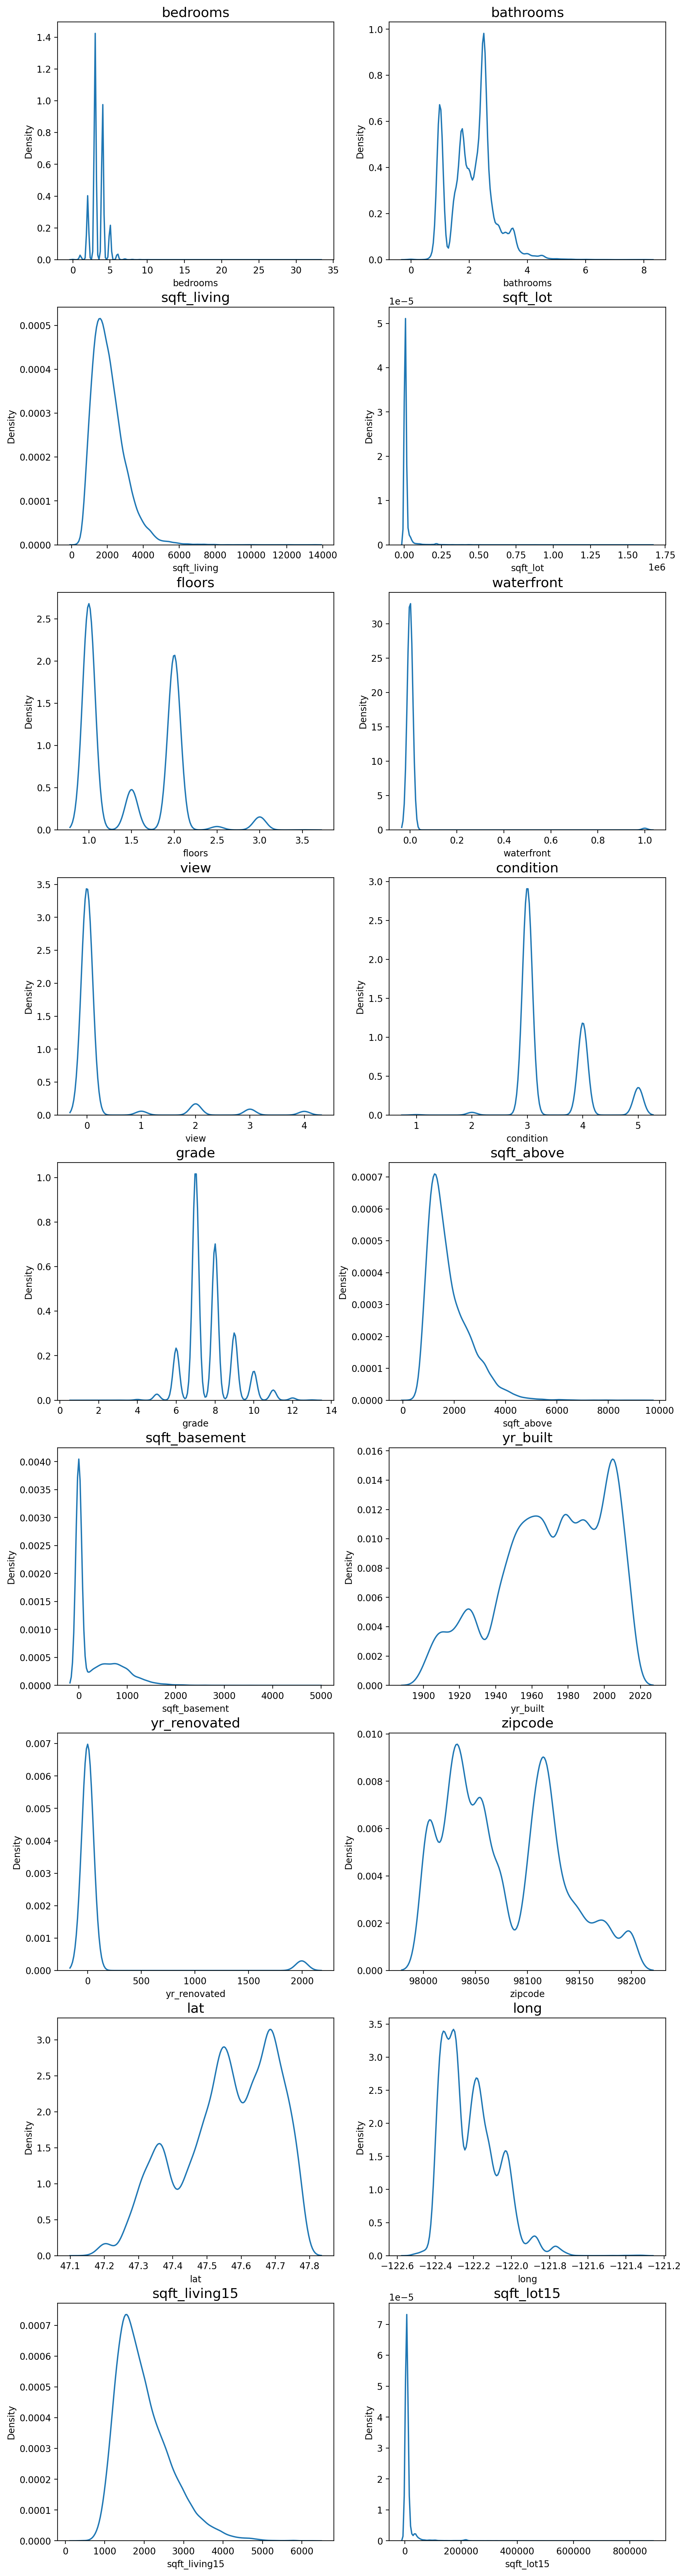

In [17]:
# 7 데이터 형테 보기

fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다. -> id가 아니라 date임
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [18]:
# 8 치우침이 심한 컬럼은 왜도 리스트에 넣어 log(x + 1)를 취함

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
# 왜도 - 데이터의 분포가 한쪽으로 얼마나 치우쳐 있는지를 나타내는 값 skew = 0 이면 대칭, 양의 외도(오른쪽 꼬리, 음의 외도 왼쪽 꼬리
for c in skew_columns:
    data[c] = np.log1p(data[c].values) 
    # log1p == log(x + 1) 1p는 plus 1(+ 1)이란 뜻, 
    # why 사용했는가? 0일때도 안전 np.log(0) -> - inf, np.log1p(0) -> 0
    # 큰 값일 경우도 눌러서 분포를 안정화함 log 0 -> -∞ , log(0 +1) -> 0, log 1 -> 0, log(1+1) -> 0.69, log 10 -> 2.30, log 11 2.39
    # data[c].values는 pandas Series -> numpy array 변경하는 것이지만, 안 붙여도 됨.

print('얍💢')

얍💢


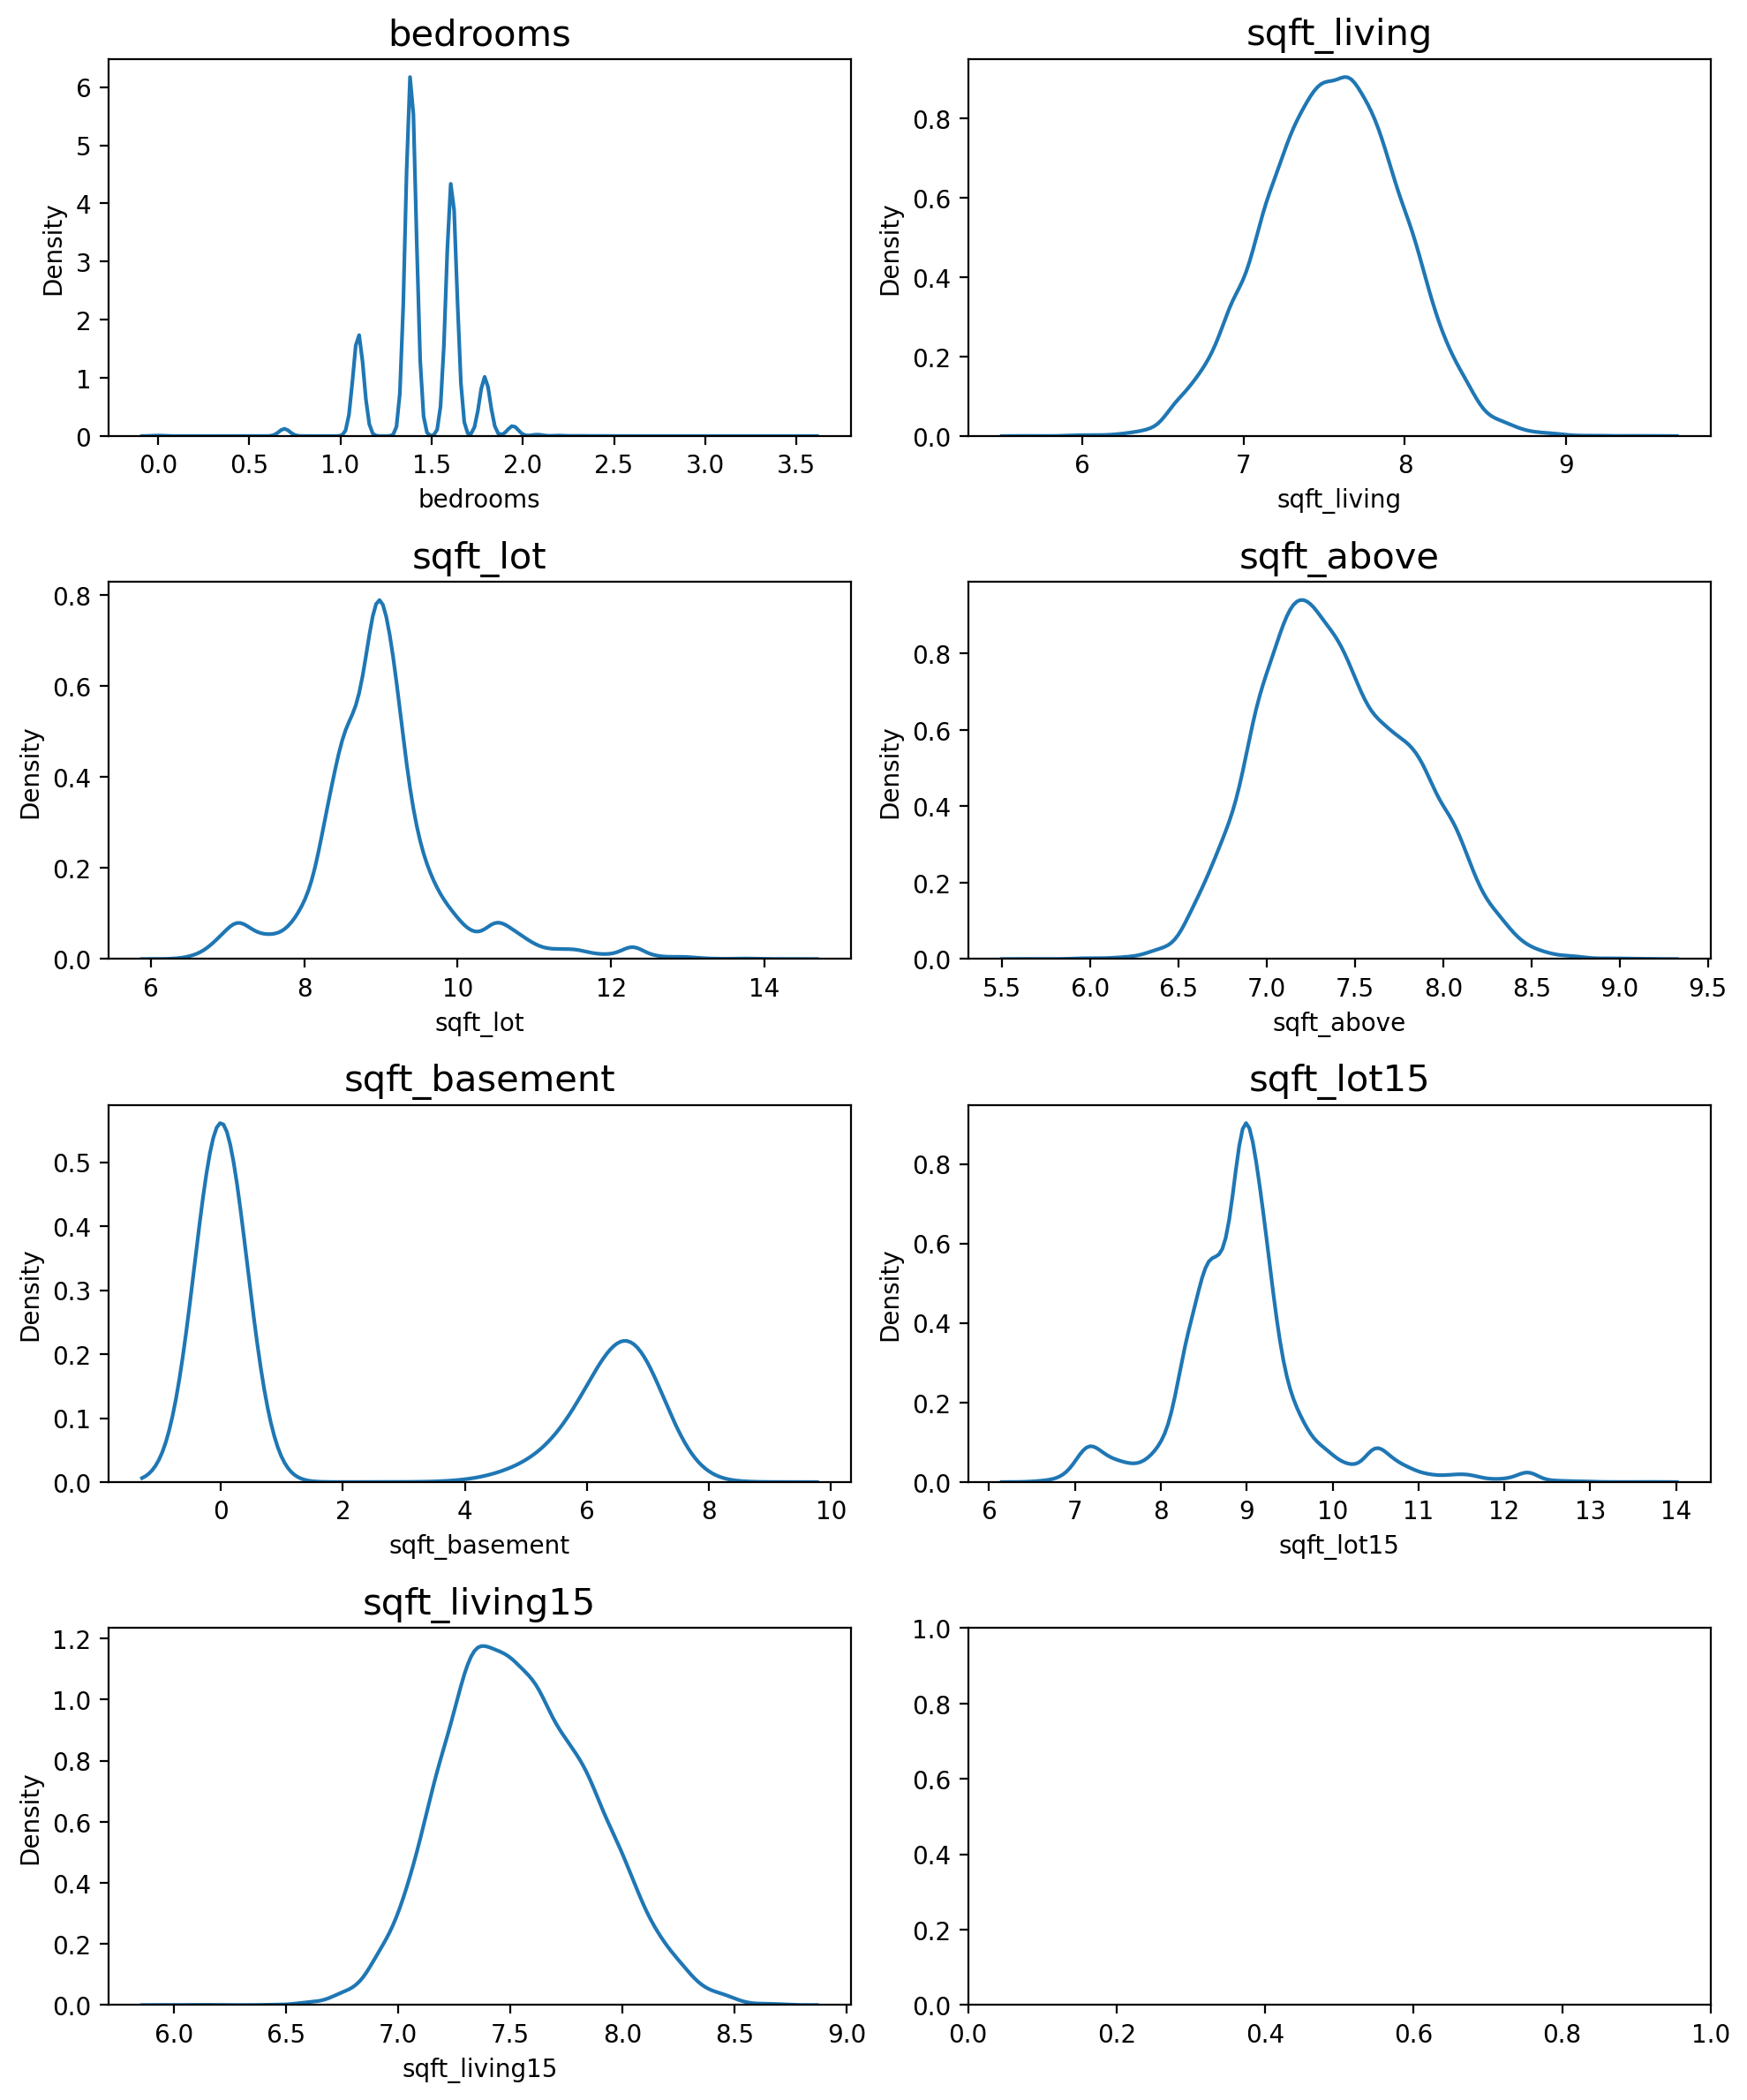

In [19]:
fig, ax = plt.subplots(4, 2, figsize=(10, 12)) # plt.subplots(3, 2, figsize=(10, 15)) 변경

count = 0
for row in range(4): # 3-> 4
    for col in range(2):
        if count == 7: # 5 -> 7
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

plt.tight_layout()

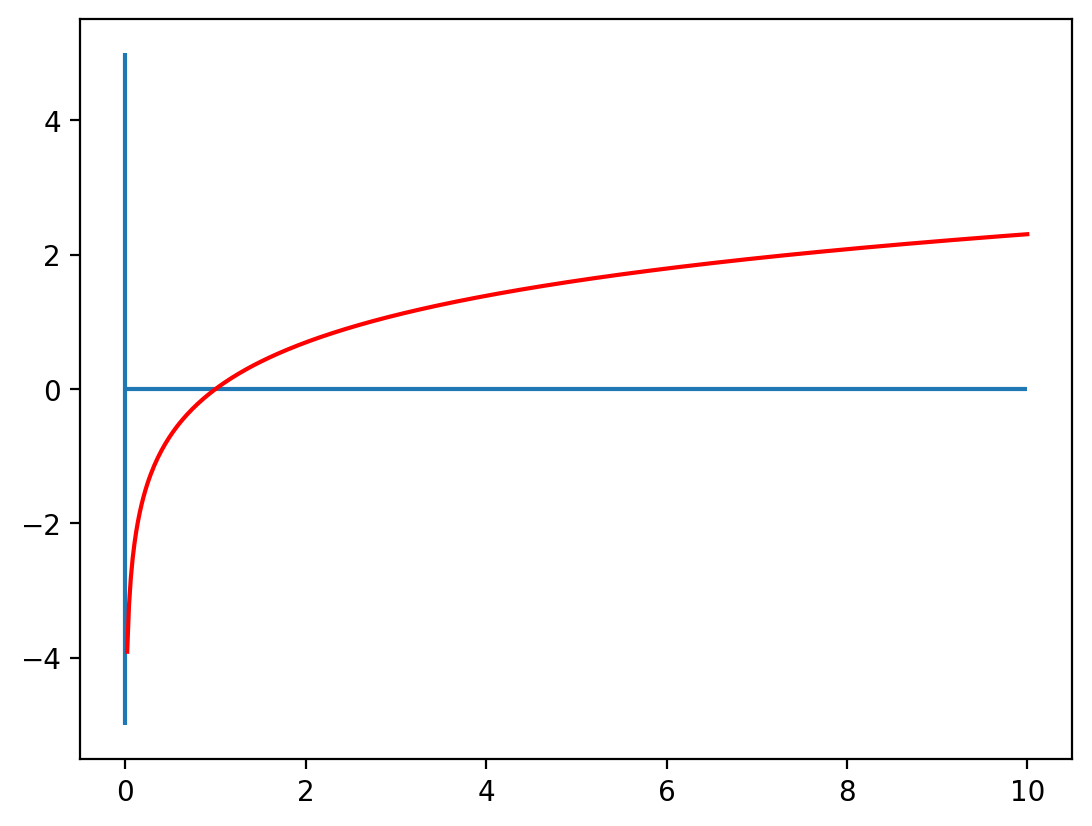

In [20]:
## 참고 로그 변환으로 왜도 줄이기
# 로그함수 형태 보기

xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

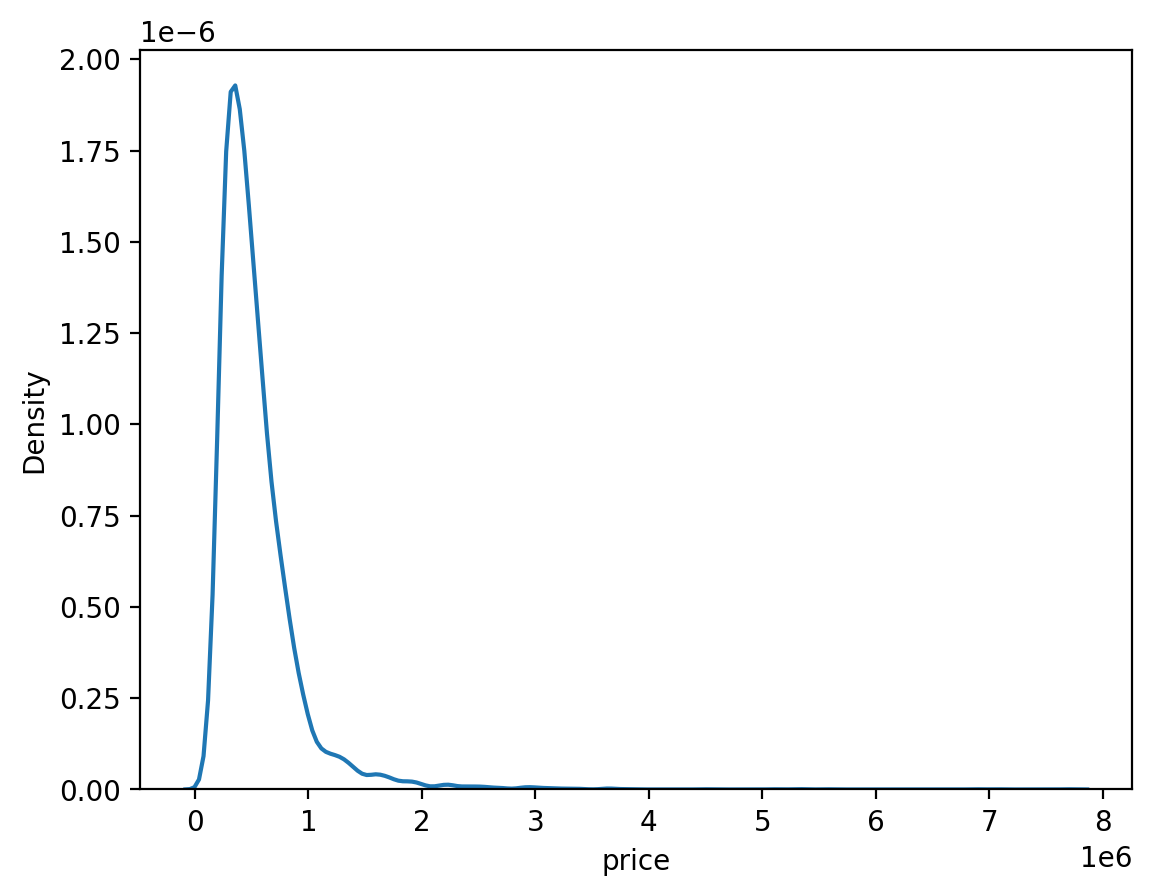

In [21]:
# 9 price 왜도 줄이기
# 원래 price의 분포
sns.kdeplot(y)
plt.show()

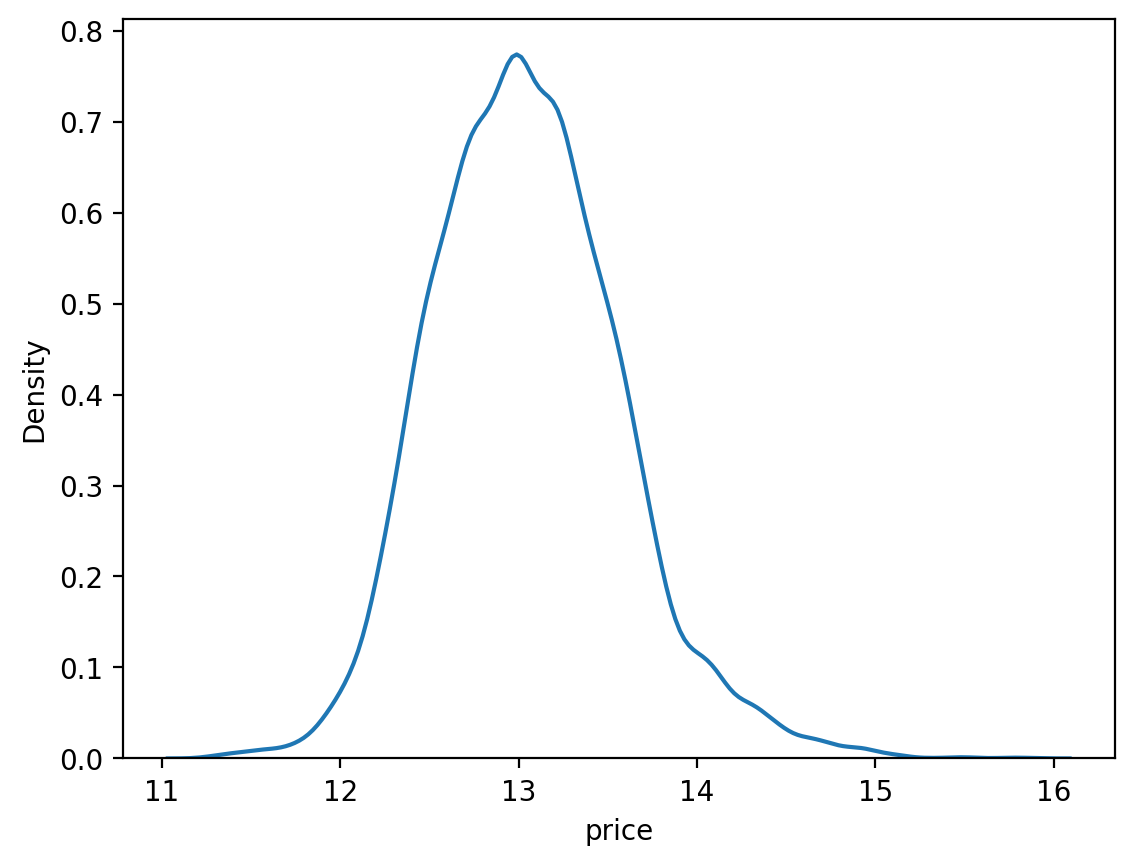

In [22]:
# Q3. 위 분포를 log 변환하게 되면 그 분포는 어떤 모양을 가지게 될까요?
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [23]:
# 10전체 데이터를 학습데이터와 테스트 데이터로 다시 분리
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


### 4 모델 설계

In [24]:
# 모델 설계 (앙상불  보팅과 에버리징)
# 앙상블 기법 중에서 회귀에 해당하는 에버리징 사용

# ✓ Average Blending
# 모델은 부스팅 계열인 gboost, xgboost, lightgbm 세 가지를 사용

gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


In [25]:
# ✓ Cross Validation 교차검증을 통해 모델 성능평가

def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('얍💢')

얍💢


In [26]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 540497.991270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 542956.681826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001868 seconds.
Y

In [27]:
# Baseline모델 (튜닝하지 않은 기준점 모델)
# Baseline 모델은 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어 주는 AveragingBlending() 함수로 사용
def AveragingBlending(models, x, y, sub_x):
    for m in models :
        m['model'].fit(x.values, y)

    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


In [28]:
# Baseline 모델(함수)를 활용하여 예측값 생성
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 540682.653143
6468


array([ 548944.53804912,  443655.17105951, 1345797.07909443, ...,
        457185.23303678,  339532.04977609,  422564.70651683],
      shape=(6468,))

In [29]:
# 제출해야할 파일의 샘플을 불러와서 구조를 파악해 봄
# 제출해야 하는 csv 파일의 샘플이 바로 data 폴더에 있는 sample_submission.csv 임

data_dir = '~/work/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()


,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [30]:
# 제출해야할 파일 샘플구조가 id와 price의 두 가지 열로 구성되어 있습니다. 
# 그렇다면 우리도 이에 맞게 id와 price로 구성된 데이터 프레임을 만들어 줌
result = pd.DataFrame({
    'id' : sub_id,
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.489445e+05
1,15036,4.436552e+05
2,15037,1.345797e+06
3,15038,3.206119e+05
4,15039,3.180479e+05


In [31]:
# 제출할 파일 생성
my_submission_path = join(data_dir, 'submission_2.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

~/work/kaggle_kakr_housing/data/submission_2.csv


### 캐글에 첫 결과 제출하기

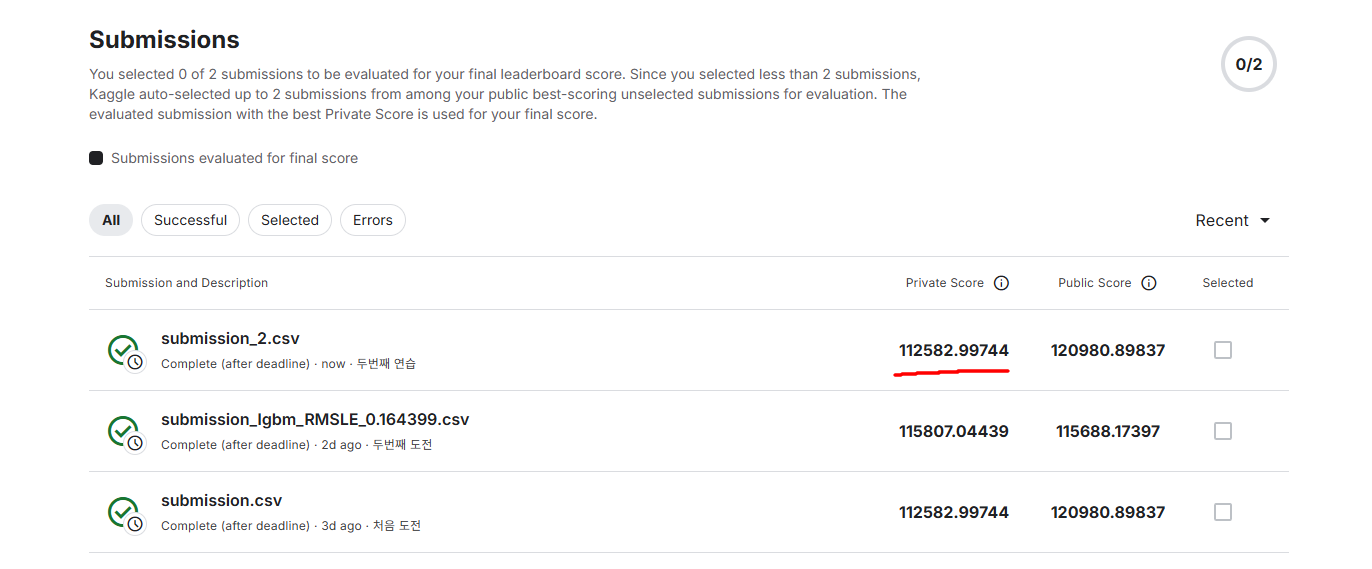

### 6 다시 한번, 내 입맛대로 데이터 준비하기

In [32]:
data_dir = '~/work/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [33]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [34]:
# train 전치리
# 1) date  전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [35]:
# 2) price 컬럼 처리
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [36]:
# 3) id 컬럼 삭제
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [37]:
# test 데이터 전처리
# date 컬럼 전처리와 id 컬럼 삭제

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [38]:
# 타겟 데이터 확인
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

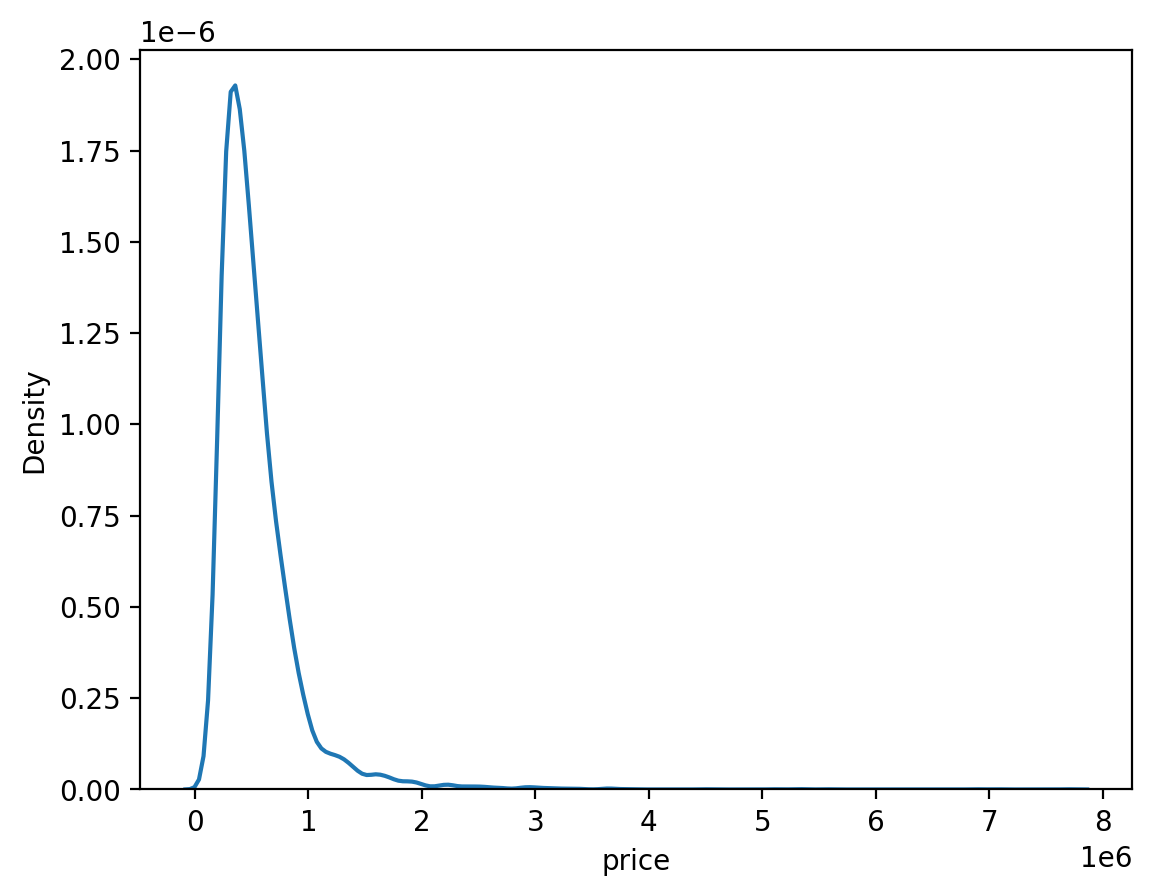

In [39]:
"""
seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인
"""

sns.kdeplot(y)
plt.show()

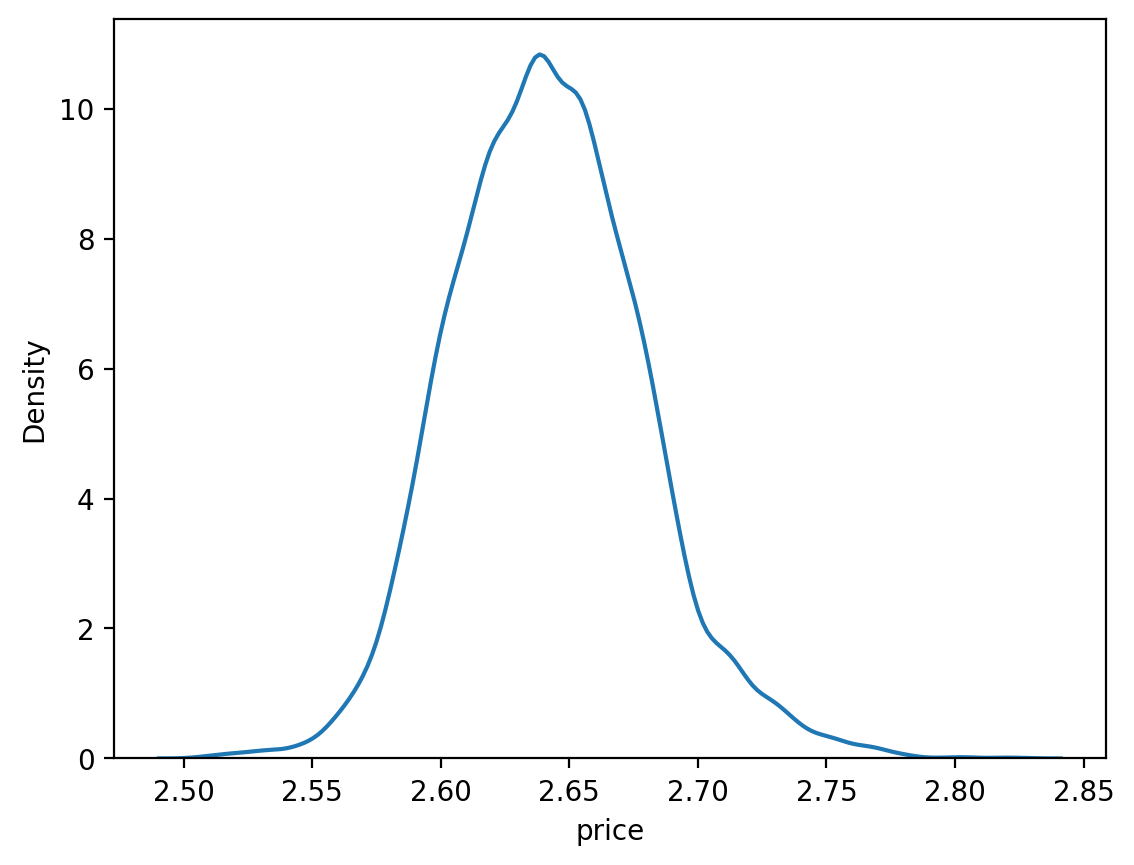

In [41]:
# 치우침 개선
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [42]:
# train data 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

### 7. 모델 튜닝을 위한 함수 만들기

In [43]:
# 라이블러리 불러오기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


In [44]:
# 1. RMSE 함수 만들기
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


In [45]:
# 모델 라이블러리 가져오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


In [46]:
# 모델 인스턴스를 만들고, model 리스트에 넣기

random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [47]:
# 각 모델의 이름 속성 얻기
gboost.__class__.__name__

'GradientBoostingRegressor'

In [48]:
# for문 안에서 각 모델 별로 학습 및 예측

df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)


    # 모델 학습
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)

    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 2.641764


{'GradientBoostingRegressor': np.float64(0.1809232218184817),
 'XGBRegressor': np.float64(0.16787828473162153),
 'LGBMRegressor': np.float64(0.16314856105233844),
 'RandomForestRegressor': np.float64(0.1772598365624751)}

In [49]:
# 4개의 모델에 대한 RMSE 값 구하는 함수 만들기
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

### 8 그리드 서치(탐색) 클래스로 하이퍼 파라미터 튜닝하기

In [50]:
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


In [51]:
#  param_grid에 탐색할 xgboost 관련 하이퍼 파라미터 준비
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [52]:
# 모델 준비, 모델은 LightGBM(lgbm) 사용
model = LGBMRegressor(random_state=random_state)

print('얍💢')

얍💢


In [53]:
from sklearn import set_config
set_config(display='text')   # HTML 출력 대신 텍스트 출력

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \  # 뒤에서 다시 -1를 곱할 것임
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 2.642040
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [54]:
# grid_model.fit 함수를 통해서 4가지 조합에 대한 실험을 모두 마침.
# 실험에 대한 결과는 다음과 같이 grid_model.cv_results_ 안에 저장

grid_model.cv_results_

{'mean_fit_time': array([0.4434628 , 0.39041748, 1.00366769, 1.25433116]),
 'std_fit_time': array([0.09433387, 0.05366093, 0.10465724, 0.1387336 ]),
 'mean_score_time': array([0.02935424, 0.0304606 , 0.05967712, 0.07670894]),
 'std_score_time': array([0.00617472, 0.00997961, 0.00948282, 0.02794989]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value=999999),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value=999999),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.00037839, -0.00027917, -0.00014791, -0.00013679]),
 'split1_test_score': array([-0.00038423, -0.00029197, -0.00015652, -0.00014476]),
 'split2_test_score': array([-0.00037037, -0.00028103, -0.00015901, -0.00014852]),
 'spl

In [55]:
# 딕셔너리 중 params에, 각각에 대한 테스트 점수만 mean_test_score에 저정
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [56]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.00036765, -0.00027737, -0.00015077, -0.00014011])

In [57]:
# 여기에 코드를 작성하세요.


results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.000368
1,1,100,-0.000277
2,10,50,-0.000151
3,10,100,-0.000140


In [58]:
# RMSE 구하기 
# scoring에 MSE에 음수를 취한 값인 neg_mean_squared_error를 입력했음
# 음수로 된 MSE였으니, -1을 곱해주고 np.sqrt로 루트 연산

results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.000368,0.019174
1,1,100,-0.000277,0.016655
2,10,50,-0.000151,0.012279
3,10,100,-0.000140,0.011837


In [59]:
# RMSE가 아니라 RMSLE, 즉 Root Mean Squared Log Error로 이름 변경
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.000368,0.019174
1,1,100,-0.000277,0.016655
2,10,50,-0.000151,0.012279
3,10,100,-0.000140,0.011837


In [60]:
#  RMSLE가 낮은 순서대로 정렬

results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.000140,0.011837
2,10,50,-0.000151,0.012279
1,1,100,-0.000277,0.016655
0,1,50,-0.000368,0.019174


In [61]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다.
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [62]:
### 제출하기
# my_GridSearch() 함수로 간단한 그리드 탐색
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 2.640862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.000140,0.011837
2,10,50,-0.000151,0.012279
1,1,100,-0.000277,0.016655
0,1,50,-0.000368,0.019174


In [63]:
# 가장 좋은 조합은 max_depth=10, n_estimators=100
# 해당 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출

model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 2.641790


array([2.64364262, 2.64014739, 2.71797999, ..., 2.6413381 , 2.61577285,
       2.63572556], shape=(6468,))

In [64]:
# 예측 결과에 np.expm1()을 씌워서 다시 원래 스케일로 되돌림

prediction = np.expm1(prediction)
prediction

array([13.06434146, 13.01526921, 14.14968879, ..., 13.03196719,
       12.67778315, 12.95343288], shape=(6468,))

In [65]:
# sample_submission.csv 파일을 가져와 봄

data_dir = '~/work/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [66]:
# 위의 데이터프레임에 우리의 모델이 예측한 값을 덮어씌우면 제출할 데이터 완성
submission['price'] = prediction
submission.head()

,id,price
0,15035,13.064341
1,15036,13.015269
2,15037,14.149689
3,15038,12.673338
4,15039,12.704526


In [67]:
# 위의 데이터를 csv 파일로 저장
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

~/work/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

## 두번째 스코어

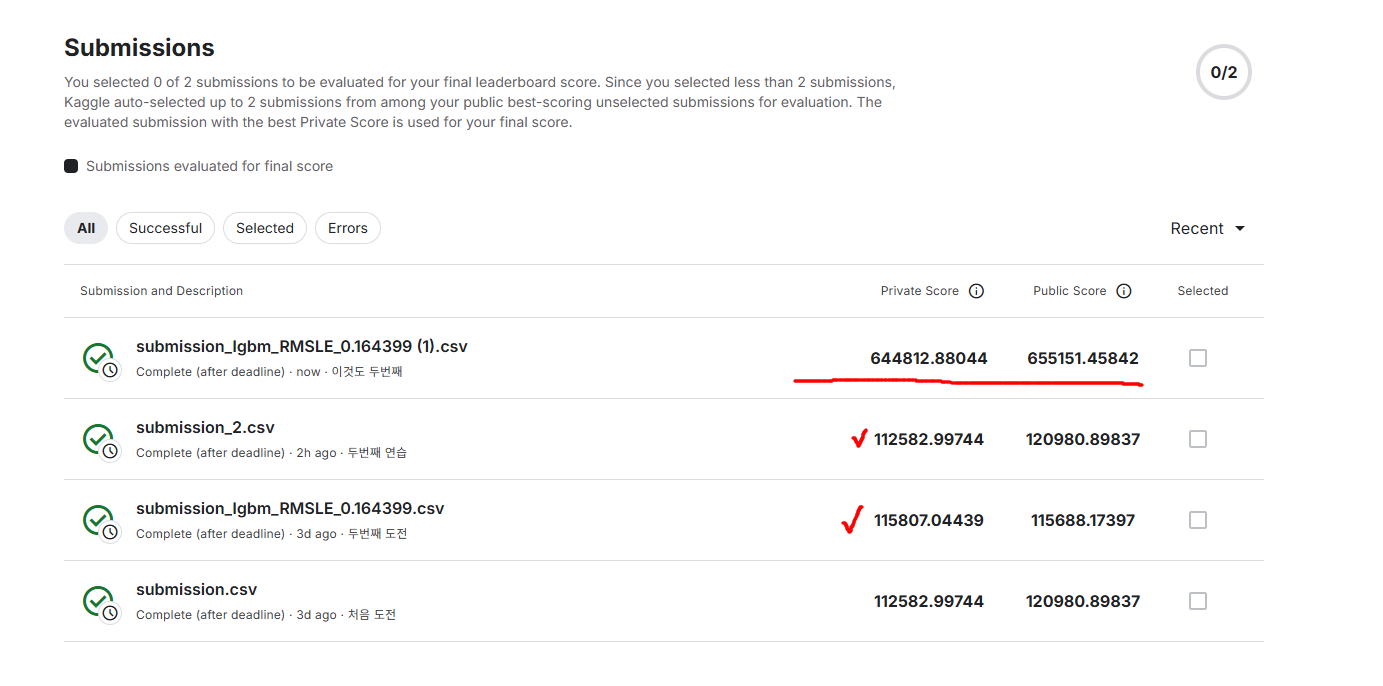

## 9 1차 코드 개선

### A 라이브러리 및 데이터 로드, 타겟 분리

In [69]:
import os
from os.path import join
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

from lightgbm import LGBMRegressor

# -------------------------
# 1) 데이터 로드
# -------------------------
data_dir = os.path.join(os.getenv('HOME'), 'work/kaggle_kakr_housing/data')
train_path = join(data_dir, 'train.csv')
test_path  = join(data_dir, 'test.csv')

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

# -------------------------
# 2) 타깃 분리 + id 저장
# -------------------------
y = train['price'].copy()
train_id = train['id'].copy()
test_id = test['id'].copy()

train.drop(['price'], axis=1, inplace=True)

print("train:", train.shape, "test:", test.shape, "y:", y.shape)

train: (15035, 20) test: (6468, 20) y: (15035,)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

### B 피처 엔지니어링 + train/test 분리

In [70]:

# -------------------------
# 3) train+test 합쳐서 동일 전처리
# train/test 분리 후 각각 전처리 → 분포 불일치 위험, Baseline처럼 concat 후 동일 전처리가 안정적
# -------------------------
all_data = pd.concat([train, test], axis=0, ignore_index=True)

# -------------------------
# 4) date 피처 엔지니어링 (연/월)
# -------------------------
# date 예: "20141013T000000"
all_data['date'] = all_data['date'].astype(str)
all_data['year'] = all_data['date'].str[:4].astype(int)
all_data['month'] = all_data['date'].str[4:6].astype(int)
all_data.drop(['date'], axis=1, inplace=True)

# -------------------------
# 5) id 제거 (모델에 불필요)
# -------------------------
all_data.drop(['id'], axis=1, inplace=True)

# -------------------------
# 6) zipcode는 범주형 처리 (중요)
# category 처리
# -------------------------
# LightGBM은 category를 잘 처리합니다.
all_data['zipcode'] = all_data['zipcode'].astype('category')

# -------------------------
# 7) 왜도(skew) 큰 피처 log1p 변환
# -------------------------
skew_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
             'sqft_living15', 'sqft_lot15', 'bedrooms']

for c in skew_cols:
    # 0 이하가 있을 가능성이 거의 없지만, 안전하게 처리
    all_data[c] = np.log1p(all_data[c].astype(float))

# -------------------------
# 8) 타깃 log 변환 (RMSLE에 유리)
# -------------------------
y_log = np.log1p(y)

# -------------------------
# 9) 다시 train/test로 분리
# -------------------------
X_train = all_data.iloc[:len(y), :].copy()
X_test  = all_data.iloc[len(y):, :].copy()

print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train: (15035, 20) X_test: (6468, 20)


### C GridSearchCV (메모리 안전 설정)

In [71]:

# -------------------------
# 10) RMSLE scorer 정의 (GridSearch용)
# -------------------------
# RMSLE scorer (log1p 스케일을 expm1로 원복 후 RMSLE 계산)
def rmsle(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# -------------------------
# 11) LightGBM + GridSearch (CV 기반)
# -------------------------

# LightGBM 모델 (내부 스레드 제한: n_jobs=1로 안전하게)
model = LGBMRegressor(
    random_state=42,
    n_estimators=800,
    learning_rate=0.05,
    n_jobs=1
)

# ✅ 조합 수를 줄인 안전 param_grid (8조합 → 5-fold면 40 fits)
param_grid = {
    'max_depth': [-1, 10],
    'num_leaves': [31, 63],
    'min_child_samples': [20, 50],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# ✅ GridSearch 병렬 제한: n_jobs=1 (메모리 안정)
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=cv,
    n_jobs=1,
    verbose=1
)

grid.fit(X_train, y_log)

print("Best params:", grid.best_params_)
print("Best CV score (neg RMSLE):", grid.best_score_)
print("Best CV RMSLE:", -grid.best_score_)

best_model = grid.best_estimator_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2299
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 20
[LightGBM] [Info] Start training from score 13.047364
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2329
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 20
[LightGBM] [Info] Start training from score 13.049396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

### D 예측 + 제출 파일 저장

In [72]:

# -------------------------
# 12) 테스트 예측 + 원복
# -------------------------
pred_log = best_model.predict(X_test)
pred = np.expm1(pred_log)

# -------------------------
# 13) 제출 파일 만들기
# -------------------------
# sample_submission 로드
sample_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(sample_path)

submission['price'] = pred

out_path = join(data_dir, f"submission_lgbm_fe_cv_{-grid.best_score_:.6f}.csv")
submission.to_csv(out_path, index=False)

print("Saved:", out_path)
submission.head()

Saved: /home/jovyan/work/kaggle_kakr_housing/data/submission_lgbm_fe_cv_0.159588.csv


,id,price
0,15035,5.340297e+05
1,15036,4.836926e+05
2,15037,1.373667e+06
3,15038,3.045742e+05
4,15039,3.310512e+05


# 캐글 제출 결과
 ## 목표 달성 110,000 이하 달성

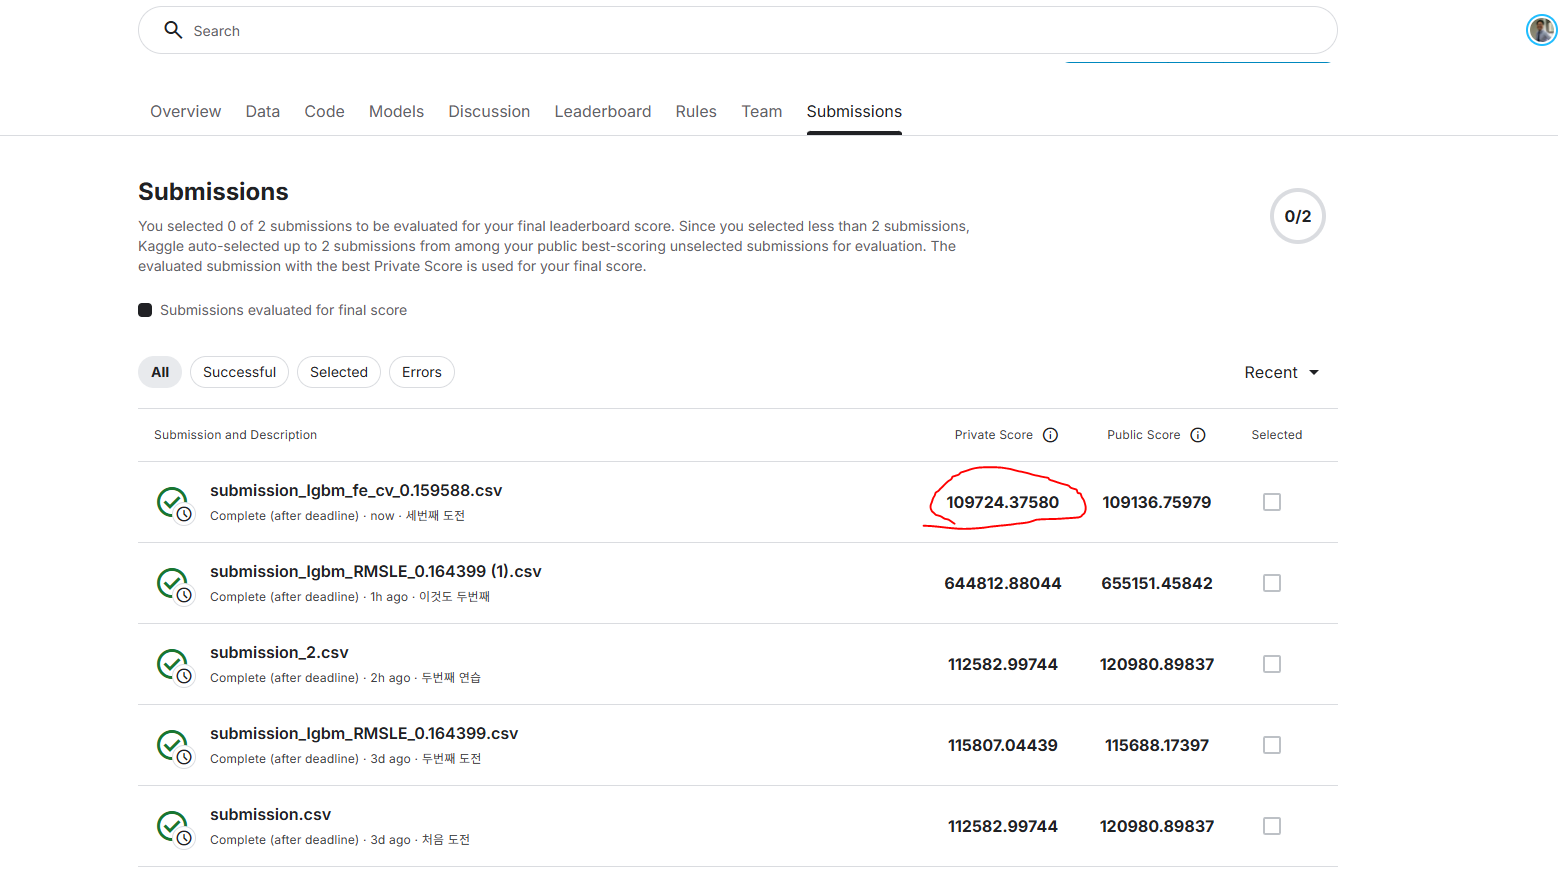


## 2차 개선

### A 로드 + 타깃 분리 

In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

# 1) 데이터 로드
data_dir = os.path.join(os.getenv('HOME'), 'work/kaggle_kakr_housing/data')
train_path = join(data_dir, 'train.csv')
test_path  = join(data_dir, 'test.csv')
sample_path = join(data_dir, 'sample_submission.csv')

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
submission = pd.read_csv(sample_path)

# 2) 타깃 분리
y = train['price'].copy()
train.drop(['price'], axis=1, inplace=True)

print("train:", train.shape, "test:", test.shape, "y:", y.shape)

train: (15035, 20) test: (6468, 20) y: (15035,)


### B 피처 엔지니어링(전처리) + train/test 분리

In [2]:
# 3) train+test concat 후 동일 전처리
all_data = pd.concat([train, test], axis=0, ignore_index=True)

# 4) date -> year/month
all_data['date'] = all_data['date'].astype(str)
all_data['year']  = all_data['date'].str[:4].astype(int)
all_data['month'] = all_data['date'].str[4:6].astype(int)
all_data.drop(['date'], axis=1, inplace=True)

# 5) id 제거
if 'id' in all_data.columns:
    all_data.drop(['id'], axis=1, inplace=True)

# 6) zipcode category
all_data['zipcode'] = all_data['zipcode'].astype('category')

# 7) skew log1p
skew_cols = [
    'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
    'sqft_basement', 'sqft_lot15', 'sqft_living15'
]
for c in skew_cols:
    all_data[c] = np.log1p(all_data[c].astype(float))

# 8) train/test 분리
train_len = len(y)
X_train = all_data.iloc[:train_len, :].copy()
X_test  = all_data.iloc[train_len:, :].copy()

# 9) y log1p
y_log = np.log1p(y)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (15035, 20) X_test: (6468, 20)


### C (메모리 안전) LGBM GridSearch + 학습

In [3]:
# 10) RMSLE scorer
def rmsle(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# 11-A) LightGBM 튜닝 (메모리 안전 설정)
base_lgbm = LGBMRegressor(
    random_state=42,
    n_estimators=600,        # 1200 -> 600 (안정 후 늘려도 됨)
    learning_rate=0.03,
    n_jobs=1                 # ✅ LGBM 내부 스레드 제한
)

# ✅ 조합 수 줄인 안전 grid (처음엔 작게!)
param_grid = {
    'max_depth': [-1, 10],
    'num_leaves': [31, 63],
    'min_child_samples': [20, 50],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0.0, 0.1],
    'reg_lambda': [0.0, 0.1],
}
# 2×2×2×1×1×2×2 = 32 조합 → 5-fold면 160 fits (그래도 꽤 큼)
# 더 줄이고 싶으면 reg_alpha/reg_lambda를 하나로 고정하세요.

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=base_lgbm,
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=cv,
    n_jobs=1,        # ✅ GridSearch 병렬 제한 (가장 중요)
    verbose=1
)

grid.fit(X_train, y_log)

best_lgbm = grid.best_estimator_
print("Best LGBM params:", grid.best_params_)
print("Best CV RMSLE:", -grid.best_score_)

# 11-B) XGB / GBoost 학습 (메모리 안전 설정)
xgb = XGBRegressor(
    random_state=42,
    n_estimators=800,         # 1200 -> 800
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective='reg:squarederror',
    tree_method='hist',       # ✅ 메모리/속도 안정
    n_jobs=1                  # ✅ XGB 스레드 제한
)

gboost = GradientBoostingRegressor(random_state=42)

xgb.fit(X_train, y_log)
gboost.fit(X_train, y_log)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2299
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 20
[LightGBM] [Info] Start training from score 13.047364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2329
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 20
[LightGBM] [Info] Start training from score 13.049396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_r

/opt/conda/lib/python3.12/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2339
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 20
[LightGBM] [Info] Start training from score 13.048122
Best LGBM params: {'colsample_bytree': 0.8, 'max_depth': -1, 'min_child_samples': 20, 'num_leaves': 63, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Best CV RMSLE: 0.1588172826329387


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:zipcode: category

### D 앙상블 예측 + 제출 저장

In [ ]:
# 13) 예측 (log 스케일) + 앙상블
pred_lgbm_log = best_lgbm.predict(X_test)
pred_xgb_log  = xgb.predict(X_test)
pred_gb_log   = gboost.predict(X_test)

# 가중치 (필요하면 조정)
w_lgbm, w_xgb, w_gb = 0.5, 0.3, 0.2
pred_ens_log = (w_lgbm * pred_lgbm_log) + (w_xgb * pred_xgb_log) + (w_gb * pred_gb_log)

# 원복
pred = np.expm1(pred_ens_log)

# 14) 제출 저장
submission['price'] = pred
out_path = join(data_dir, f"submission_ens_fe_lgbm_xgb_gb_{-grid.best_score_:.6f}.csv")
submission.to_csv(out_path, index=False)
print("Saved:", out_path)

submission.head()

In [ ]:
# 2차 개선 결과
